# Chapter 13: Performance Reporting

In [14]:
import yfinance as yf

In [15]:
class Allocation:
  def __init__(self, ticker, percentage):
    self.ticker = ticker
    self.percentage = percentage
    self.units = 0.0

class Portfolio:

  def __init__(self, tickerString: str, expectedReturn: float, portfolioName: str, riskBucket: int):

    self.name = portfolioName
    self.riskBucket = riskBucket
    self.expectedReturn = expectedReturn
    self.allocations = []

    from pypfopt.efficient_frontier import EfficientFrontier
    from pypfopt import risk_models
    from pypfopt import expected_returns

    df = self.__getDailyPrices(tickerString, "20y")

    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)

    ef = EfficientFrontier(mu, S)

    ef.efficient_return(expectedReturn)
    self.expectedRisk = ef.portfolio_performance()[1]
    portfolioWeights = ef.clean_weights()

    for key, value in portfolioWeights.items():
      newAllocation = Allocation(key, value)
      self.allocations.append(newAllocation)

  def __getDailyPrices(self, tickerStringList, period):
    data = yf.download(tickerStringList, group_by="Ticker", period=period)
    data = data.iloc[:, data.columns.get_level_values(1)=="Close"]
    data = data.dropna()
    data.columns = data.columns.droplevel(1)
    return data

  def printPortfolio(self):
    print("Portfolio Name: " + self.name)
    print("Risk Bucket: " + str(self.riskBucket))
    print("Expected Return: " + str(self.expectedReturn))
    print("Expected Risk: " + str(self.expectedRisk))
    print("Allocations: ")
    for allocation in self.allocations:
      print("Ticker: " + allocation.ticker + ", Percentage: " + str(allocation.percentage))

  @staticmethod
  def getPortfolioMapping(riskToleranceScore, riskCapacityScore):
    import pandas as pd
    allocationLookupTable=pd.read_csv('./Data/Risk Mapping Lookup.csv')
    matchTol = (allocationLookupTable['Tolerance_min'] <= riskTolScore) & (allocationLookupTable['Tolerance_max'] >= riskTolScore)
    matchCap = (allocationLookupTable['Capacity_min'] <= riskCapScore) & (allocationLookupTable['Capacity_max'] >= riskCapScore)
    portfolioID = allocationLookupTable['Portfolio'][(matchTol & matchCap)]
    return portfolioID.values[0]

In [16]:
# Can use for Goal or Acct level
# Need date, portfoliovalue, cashflow +/-
import pandas as pd
history = pd.DataFrame(columns=['Date','Value','Cashflow'])
history = history.set_index('Date')
new_row = pd.Series({'Value':0,'Cashflow':0}, name=pd.Timestamp('2019-12-30'))
history = history.append(new_row)
new_row = pd.Series({'Value':100000,'Cashflow':100000}, name=pd.Timestamp('2019-12-31'))
history = history.append(new_row)
new_row = pd.Series({'Value':77985,'Cashflow':0}, name=pd.Timestamp('2020-03-23'))
history = history.append(new_row)
new_row = pd.Series({'Value':110828,'Cashflow':0}, name=pd.Timestamp('2020-12-31'))
history = history.append(new_row)
print(history)

             Value Cashflow
Date                       
2019-12-30       0        0
2019-12-31  100000   100000
2020-03-23   77985        0
2020-12-31  110828        0


In [17]:
def calculatePNL_TWRR(history: pd.DataFrame, annualized: bool=False):
  twrr = 1.0
  beginValue = history.iloc[0]['Value']
  for period in range(len(history)-1):
    endValue = history.iloc[period+1]['Value']
    cashflow = history.iloc[period+1]['Cashflow']
    if beginValue > 0.0 or cashflow > 0.0:
      periodReturn = (endValue-(beginValue+cashflow))/(beginValue+cashflow)
      twrr = (1+periodReturn)*twrr
    beginValue = endValue

  twrr = twrr - 1

  if annualized:
    from dateutil import parser
    startDateTime = history.iloc[0].name
    endDateTime = history.iloc[len(history)-1].name
    from dateutil.relativedelta import relativedelta
    delta = relativedelta(endDateTime, startDateTime)
    return twrr/delta.years
  else:
    return twrr

In [18]:
print(calculatePNL_TWRR(history=history))
print(calculatePNL_TWRR(history=history,annualized=True))

0.10827999999999993
0.10827999999999993


In [19]:
history = pd.DataFrame(columns=['Date','Value','Cashflow'])
history = history.set_index('Date')
new_row = pd.Series({'Value':0,'Cashflow':0}, name=pd.Timestamp('2019-12-30'))
history = history.append(new_row)
new_row = pd.Series({'Value':100000,'Cashflow':100000}, name=pd.Timestamp('2019-12-31'))
history = history.append(new_row)
new_row = pd.Series({'Value':77985,'Cashflow':0}, name=pd.Timestamp('2020-03-23'))
history = history.append(new_row)
new_row = pd.Series({'Value':87985,'Cashflow':10000}, name=pd.Timestamp('2020-03-23'))
history = history.append(new_row)
new_row = pd.Series({'Value':125039,'Cashflow':0}, name=pd.Timestamp('2020-12-31'))
history = history.append(new_row)
print(history)

             Value Cashflow
Date                       
2019-12-30       0        0
2019-12-31  100000   100000
2020-03-23   77985        0
2020-03-23   87985    10000
2020-12-31  125039        0


In [20]:
print(calculatePNL_TWRR(history=history))
#print(calculatePNL_TWRR(history=history,annualized=True))

0.10827600329601639


In [21]:
history = pd.DataFrame(columns=['Date','Value','Cashflow'])
history = history.set_index('Date')
new_row = pd.Series({'Value':0,'Cashflow':0}, name=pd.Timestamp('2019-12-30'))
history = history.append(new_row)
new_row = pd.Series({'Value':100000,'Cashflow':100000}, name=pd.Timestamp('2019-12-31'))
history = history.append(new_row)
new_row = pd.Series({'Value':77985,'Cashflow':0}, name=pd.Timestamp('2020-03-23'))
history = history.append(new_row)
new_row = pd.Series({'Value':67985,'Cashflow':-10000}, name=pd.Timestamp('2020-03-23'))
history = history.append(new_row)
new_row = pd.Series({'Value':96616,'Cashflow':0}, name=pd.Timestamp('2020-12-31'))
history = history.append(new_row)
print(history)

             Value Cashflow
Date                       
2019-12-30       0        0
2019-12-31  100000   100000
2020-03-23   77985        0
2020-03-23   67985   -10000
2020-12-31   96616        0


In [22]:
print(calculatePNL_TWRR(history=history))

0.1082737015518127


In [23]:
# MWRR: just show formula, not relevant for Robo (hedge funds etc.)

In [24]:
data = yf.download("VTI TLT IEI GLD DBC", group_by="Ticker", period="5y")
data = data.iloc[:, data.columns.get_level_values(1)=="Close"]
data = data.dropna()
data.columns = data.columns.droplevel(1)
data

[*********************100%***********************]  5 of 5 completed


,GLD,IEI,DBC,VTI,TLT
Date,,,,,
2018-01-25 00:00:00-05:00,127.970001,121.239998,17.120001,145.339996,124.050003
2018-01-26 00:00:00-05:00,128.070007,120.980003,17.250000,146.860001,123.589996
2018-01-29 00:00:00-05:00,127.349998,120.839996,17.200001,145.899994,122.730003
2018-01-30 00:00:00-05:00,126.800003,120.760002,17.080000,144.380005,122.010002
2018-01-31 00:00:00-05:00,127.650002,120.669998,17.100000,144.429993,122.730003
...,...,...,...,...,...
2023-01-19 00:00:00-05:00,179.889999,117.800003,24.940001,195.020004,107.949997
2023-01-20 00:00:00-05:00,179.289993,117.370003,25.090000,198.759995,106.199997
2023-01-23 00:00:00-05:00,179.630005,117.080002,25.150000,201.279999,105.699997


In [25]:
data.iloc[0]

GLD    127.970001
IEI    121.239998
DBC     17.120001
VTI    145.339996
TLT    124.050003
Name: 2018-01-25 00:00:00-05:00, dtype: float64

In [26]:
myPortfolio = Portfolio("VTI TLT IEI GLD DBC", expectedReturn = 0.05, portfolioName = "Moderate", riskBucket = 3)

(CVXPY) Jan 25 04:25:17 PM: Encountered unexpected exception importing solver ECOS:
ImportError("dlopen(/Users/akiranin/miniforge3/lib/python3.10/site-packages/_ecos.cpython-310-darwin.so, 0x0002): tried: '/Users/akiranin/miniforge3/lib/python3.10/site-packages/_ecos.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/akiranin/miniforge3/lib/python3.10/site-packages/_ecos.cpython-310-darwin.so' (no such file), '/Users/akiranin/miniforge3/lib/python3.10/site-packages/_ecos.cpython-310-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))")
(CVXPY) Jan 25 04:25:17 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/akiranin/miniforge3/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so, 0x0002): tried: '/Users/akiranin/miniforge3/lib/python3.10/site-packages/_scs_direct.cpython-310-darwin.so' (mach-o file, but 

SolverError: Either candidate conic solvers (['SCIPY']) do not support the cones output by the problem (SOC, NonNeg, Zero), or there are not enough constraints in the problem.

In [27]:
totalValue = 0.0
for allocation in myPortfolio.allocations:
  price = data.iloc[0][allocation.ticker]
  value = allocation.units * price
  print(allocation.ticker + ": " + str(value))
  totalValue += value
print(totalValue)

NameError: name 'myPortfolio' is not defined

In [ ]:
cashInvested = 0
history = pd.DataFrame(columns=['Date','Value','Cashflow'])
history = history.set_index('Date')
new_row = pd.Series({'Value':totalValue,'Cashflow':cashInvested}, name=data.iloc[0].name)
history = history.append(new_row)
history

,Value,Cashflow
Date,,
2017-12-06,8.162197,0.0


In [ ]:
totalValue = 0.0
for allocation in myPortfolio.allocations:
  price = data.iloc[len(data)-1][allocation.ticker]
  value = allocation.units * price
  print(allocation.ticker + ": " + str(value))
  totalValue += value
print(totalValue)


IEI: 1.9532211058944307
TLT: 1.0288098185209262
DBC: 0.0
GLD: 3.5615402379965455
VTI: 3.324086314705318
9.86765747711722


In [ ]:
cashInvested = 0
new_row = pd.Series({'Value':totalValue,'Cashflow':cashInvested}, name=data.iloc[len(data)-1].name)
history = history.append(new_row)
history

,Value,Cashflow
Date,,
2017-12-06,8.162197,0.0
2022-12-05,9.867657,0.0


In [ ]:
print(calculatePNL_TWRR(history=history))
print(calculatePNL_TWRR(history=history,annualized=True))

0.20894620157141208
0.05223655039285302


In [ ]:
# Benchmarking with charts and P&L (TWRR)

In [ ]:
#benchmarkPortfolio(None, "SPY", 5)
benchmarkTicker = "SPY"
data = yf.download(benchmarkTicker, group_by="Ticker", period="5y")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-06,263.299988,263.730011,262.709991,263.239990,241.564499,75898600
2017-12-07,264.070007,264.429993,262.940002,264.070007,242.326096,77218600
2017-12-08,265.160004,265.519989,264.029999,265.510010,243.647552,76563900
2017-12-11,266.309998,266.380005,265.480011,266.309998,244.381653,83077500
2017-12-12,267.209991,267.320007,266.350006,266.779999,244.812988,85195800
...,...,...,...,...,...,...
2022-11-29,396.049988,397.299988,393.299988,395.230011,395.230011,52310000
2022-11-30,395.489990,407.679993,393.480011,407.679993,407.679993,144566700
2022-12-01,408.769989,410.000000,404.750000,407.380005,407.380005,76398200


In [ ]:
data = data.iloc[:, data.columns.get_level_values(0)=="Close"]
data = data.rename(columns={"Close": benchmarkTicker})
data = data.dropna()
data

,SPY
Date,
2017-12-06,263.239990
2017-12-07,264.070007
2017-12-08,265.510010
2017-12-11,266.309998
2017-12-12,266.779999
...,...
2022-11-29,395.230011
2022-11-30,407.679993
2022-12-01,407.380005


In [ ]:
data[benchmarkTicker] = 100*(data[benchmarkTicker] / data.iloc[0][benchmarkTicker])-100
data

,SPY
Date,
2017-12-06,0.000000
2017-12-07,0.315308
2017-12-08,0.862338
2017-12-11,1.166239
2017-12-12,1.344784
...,...
2022-11-29,50.140566
2022-11-30,54.870083
2022-12-01,54.756124


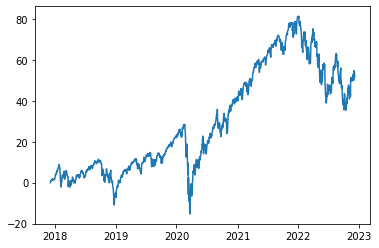

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data)
plt.show()

In [ ]:
tickerString = ""
portfolio = myPortfolio
years=5

for allocation in portfolio.allocations:
  tickerString = tickerString + allocation.ticker + " "

data2 = yf.download(tickerString, group_by="Ticker", period=str(years)+"y")
data2 = data2.iloc[:, data2.columns.get_level_values(1)=="Close"]
data2 = data2.dropna()
data2.columns = data2.columns.droplevel(1)

[*********************100%***********************]  5 of 5 completed


In [ ]:
for allocation in portfolio.allocations:
  data2[allocation.ticker] = data2[allocation.ticker] * allocation.percentage

In [ ]:
data2

,TLT,IEI,DBC,GLD,VTI
Date,,,,,
2017-12-06,12.759062,23.154137,0.0,44.289020,46.291932
2017-12-07,12.659132,23.133359,0.0,43.706221,46.476788
2017-12-08,12.660132,23.135248,0.0,43.702534,46.719832
2017-12-11,12.634150,23.118247,0.0,43.529169,46.829377
2017-12-12,12.629153,23.108802,0.0,43.580810,46.880723
...,...,...,...,...,...
2022-11-29,10.190862,21.746905,0.0,60.024586,67.765669
2022-11-30,10.265809,21.894241,0.0,60.791816,69.853818
2022-12-01,10.568597,21.992463,0.0,61.909461,69.894895


In [ ]:
data2["Total"] = data2[list(data2.columns)].sum(axis=1)
data2["Portfolio"] = 100*(data2["Total"] / data2.iloc[0]["Total"])-100

In [ ]:
data2

,TLT,IEI,DBC,GLD,VTI,Total,Portfolio
Date,,,,,,,
2017-12-06,12.759062,23.154137,0.0,44.289020,46.291932,126.494151,0.000000
2017-12-07,12.659132,23.133359,0.0,43.706221,46.476788,125.975499,-0.410020
2017-12-08,12.660132,23.135248,0.0,43.702534,46.719832,126.217746,-0.218512
2017-12-11,12.634150,23.118247,0.0,43.529169,46.829377,126.110943,-0.302945
2017-12-12,12.629153,23.108802,0.0,43.580810,46.880723,126.199488,-0.232946
...,...,...,...,...,...,...,...
2022-11-29,10.190862,21.746905,0.0,60.024586,67.765669,159.728023,26.273050
2022-11-30,10.265809,21.894241,0.0,60.791816,69.853818,162.805684,28.706096
2022-12-01,10.568597,21.992463,0.0,61.909461,69.894895,164.365416,29.939143


In [ ]:
data2 = data2.filter(['Portfolio'])

In [ ]:
data2

,Portfolio
Date,
2017-12-06,0.000000
2017-12-07,-0.410020
2017-12-08,-0.218512
2017-12-11,-0.302945
2017-12-12,-0.232946
...,...
2022-11-29,26.273050
2022-11-30,28.706096
2022-12-01,29.939143


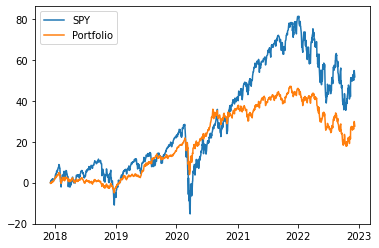

In [ ]:
#plt.plot(data)
#plt.plot(data2)
plt.plot(data, label=benchmarkTicker)
plt.plot(data2, label="Portfolio")
plt.legend(loc="upper left")
plt.show()

In [ ]:
profitBenchmark = data.iloc[len(data)-1][benchmarkTicker]/100
profitPortfolio = data2.iloc[len(data2)-1]["Portfolio"]/100

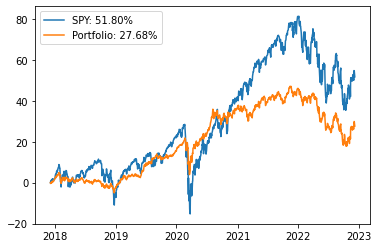

In [ ]:
plt.plot(data, label=benchmarkTicker + ": " + '{0:.2f}'.format(profitBenchmark*100) + "%")
plt.plot(data2, label="Portfolio: " + '{0:.2f}'.format(profitPortfolio*100) + "%")
plt.legend(loc="upper left")
plt.show()

In [ ]:
def benchmarkPortfolio(portfolio: Portfolio, benchmarkTicker: str, years: int):
  import matplotlib.pyplot as plt 

  # Get Benchmark data
  data = yf.download(benchmarkTicker, group_by="Ticker", period=str(years)+"y")
  data = data.iloc[:, data.columns.get_level_values(0)=="Close"]
  data = data.rename(columns={"Close": benchmarkTicker})
  data = data.dropna()
  data[benchmarkTicker] = 100*(data[benchmarkTicker] / data.iloc[0][benchmarkTicker])-100

  # Get Portfolio data
  tickerString=""
  for allocation in portfolio.allocations:
    tickerString = tickerString + allocation.ticker + " "
  data2 = yf.download(tickerString, group_by="Ticker", period=str(years)+"y")
  data2 = data2.iloc[:, data2.columns.get_level_values(1)=="Close"]
  data2 = data2.dropna()
  data2.columns = data2.columns.droplevel(1)
  for allocation in portfolio.allocations:
    data2[allocation.ticker] = data2[allocation.ticker] * allocation.percentage
  data2["Total"] = data2[list(data2.columns)].sum(axis=1)
  data2["Portfolio"] = 100*(data2["Total"] / data2.iloc[0]["Total"])-100
  data2 = data2.filter(['Portfolio'])

  # Calculate PNL
  profitBenchmark = data.iloc[len(data)-1][benchmarkTicker]/100
  profitPortfolio = data2.iloc[len(data2)-1]["Portfolio"]/100

  # Plot
  plt.plot(data, label=benchmarkTicker + ": " + '{0:.2f}'.format(profitBenchmark*100) + "%")
  plt.plot(data2, label="Portfolio: " + '{0:.2f}'.format(profitPortfolio*100) + "%")
  plt.legend(loc="upper left")
  plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  5 of 5 completed


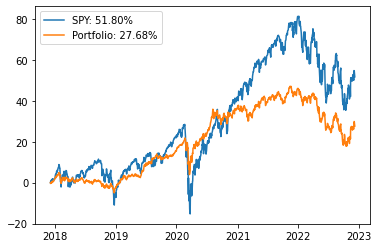

In [ ]:
benchmarkPortfolio(portfolio=myPortfolio, benchmarkTicker="SPY", years=5)